In [77]:
using Plots
using FFTW
using DSP
using StatsPlots
using StatsBase
using Statistics

# Laser Stimulation Feature

This notebook will attempt to visualise the fluctuation of O2 and LFP readings after laser stimulation has occurred.

## Data Importing

In [78]:
include("../helpers/importing.jl")
lfp = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 101/")
o2 = import_o2("Exp 2/R7/o2 r7.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => [328293.0, 450314.0, 495567.0, 535427.0, 627203.0, 731830.0, …
  "sync"       => [30452.0, 40944.0, 51395.0, 61876.0, 72372.0, 82849.0, 93294.…
  "data"       => [-269.721, -269.721, -269.721, -269.721, -269.721, -269.721, …
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  1.5976f…

## Extracting Envelope of LFP Data

In [104]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp["data"][channel,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 45]
lfp_envelopes = []
for i in 1:4
    F = fft(lfp["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, abs.(hilbert(banded_lfp)))
end
lfp_envelopes

4-element Vector{Any}:
 Float32[0.109965876, 0.119730115, 0.13008651, 0.14100732, 0.15243986, 0.16430683, 0.17650767, 0.18891968, 0.20140402, 0.21380952  …  0.040679827, 0.04566127, 0.051053923, 0.056842927, 0.06302867, 0.06962733, 0.076666184, 0.08418154, 0.09221326, 0.10079832]
 Float32[0.11568943, 0.13426997, 0.15260221, 0.17035778, 0.1872089, 0.20283468, 0.21693024, 0.2292163, 0.23944859, 0.24743009  …  0.036052894, 0.02818608, 0.020144476, 0.0151887685, 0.019384908, 0.03084362, 0.045429032, 0.061702278, 0.07908067, 0.09718583]
 Float32[0.6344022, 0.6539785, 0.6689679, 0.6788789, 0.6833267, 0.6820432, 0.6748858, 0.66184175, 0.6430289, 0.6186926  …  0.3440145, 0.36862323, 0.39636898, 0.42651904, 0.45825565, 0.49072203, 0.52305114, 0.55438924, 0.5839088, 0.6108237]
 Float32[0.37666124, 0.39336157, 0.4080388, 0.42043963, 0.430366, 0.43768302, 0.44232637, 0.44430602, 0.4437089, 0.4407008  …  0.17744641, 0.19402376, 0.21240328, 0.23221396, 0.25305524, 0.27451396, 0.29617187, 0.31761393,

## Band-Pass Filtering O2 Data

In [80]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2["data"])
freqs = fftfreq(length(o2["data"]), sampling_rate)

band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2 = real(ifft(band_pass_F))

1597615-element Vector{Float32}:
  0.49391225
  0.5759197
  0.65408814
  0.7261298
  0.7901367
  0.8446827
  0.8888846
  0.92242074
  0.94550717
  0.958839
  ⋮
 -0.040919203
 -0.017872652
  0.015638491
  0.059826728
  0.11436706
  0.17837344
  0.25041714
  0.32858807
  0.41059664

## Visualising Laser Stimulation Effect

### Single Event Effect

This section will plot the effect after a single laser event has occurred

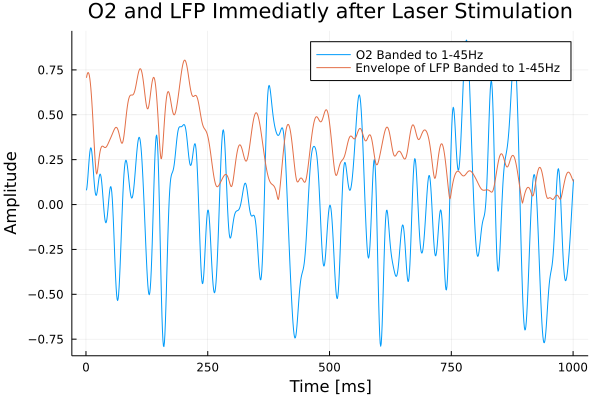

In [109]:
laser_flag = 1

o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_start = findall(x->x==lfp["laser"]["on"][laser_flag], lfp["timestamps"])[1]
increment = 1000

plot(banded_o2[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!(lfp_envelopes[1][lfp_start:lfp_start+increment], label="Envelope of LFP Banded to 1-45Hz")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [111]:
for i in 1:4
    core = cor(banded_o2[o2_start:o2_start+increment], lfp_envelopes[i][lfp_start:lfp_start+increment])
    println("Channel $(i) correlation is: $(core)")
end

Channel 1 correlation is: 0.22563057
Channel 2 correlation is: 0.23847064
Channel 3 correlation is: 0.1379415
Channel 4 correlation is: 0.13691416


### All Events Averaged

This section will average the data immediately after each event and plot the result.

In [112]:
o2_starts = findall(x->x in o2["laser"][laser_flag], o2["timestamps"])
lfp_starts = findall(x->x in lfp["laser"]["on"][laser_flag], lfp["timestamps"])
increment = 1000

diffs = o2["laser"][1:10] - lfp["laser"]["on"][1:10]

o2_subset_mean = zeros(increment+1)
lfp_subset_mean = zeros(increment+1)

for i in o2_starts
    o2_subset_mean += standardize(ZScoreTransform, banded_o2[i:i+increment])
end

for i in 1:4
    for j in lfp_starts
        lfp_subset_mean += standardize(ZScoreTransform, lfp_envelopes[i][j:j+increment])
    end
end

o2_subset_mean ./= length(o2_starts)
lfp_subset_mean ./= length(lfp_starts)
lfp_subset_mean ./= 4

1001-element Vector{Float64}:
  0.9758074060082436
  1.0682418793439865
  1.139017015695572
  1.186647903174162
  1.210251573473215
  1.2095033042132854
  1.1846105586737394
  1.1363046243786812
  1.0658266097307205
  0.9749083444476128
  ⋮
 -0.8913818746805191
 -0.8897814154624939
 -0.8853222727775574
 -0.8743596151471138
 -0.8527057692408562
 -0.8180647306144238
 -0.7718090936541557
 -0.7174371257424355
 -0.6583673804998398

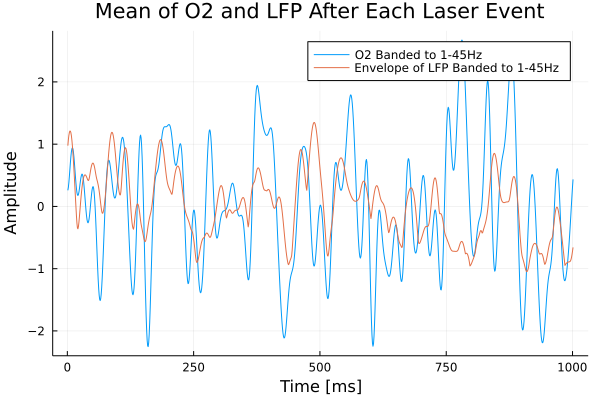

In [113]:
plot(o2_subset_mean, label="O2 Banded to 1-45Hz")
plot!(lfp_subset_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("Mean of O2 and LFP After Each Laser Event")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [114]:
cor(o2_subset_mean, lfp_subset_mean)

0.34241566650557964